## Credit Card Fraud Detection

**Use Case:** The credit-card company has released an anonymized list of time-recorded European card transactions to detect fraudulent credit-card transactions for two days in September 2013. The data contains a highly imbalanced (small) percentage of transactions that are fraudulent. The goal is to train the computer to detect fraudulent transactions. To assess the performance of various machine/deep-learning algorithms, we carry out and evaluate two popular models that are often used to cope with imbalanced datasets. They are *autoencoder neural networks* and *decision trees*. 

**Data Source:** Kraggle: https://www.kaggle.com/mlg-ulb/creditcardfraud


### Data inspection and ETL

#### The CSV file creditcard.csv is downloaded and stored in IBM Cloud Object Storage. Data from it are then extracted and converted to Spark dataframe with appropriate credentials.

In [1]:
# The code was removed by Watson Studio for sharing.

[Row(Time=u'0', V1=u'-1.3598071336738', V2=u'-0.0727811733098497', V3=u'2.53634673796914', V4=u'1.37815522427443', V5=u'-0.338320769942518', V6=u'0.462387777762292', V7=u'0.239598554061257', V8=u'0.0986979012610507', V9=u'0.363786969611213', V10=u'0.0907941719789316', V11=u'-0.551599533260813', V12=u'-0.617800855762348', V13=u'-0.991389847235408', V14=u'-0.311169353699879', V15=u'1.46817697209427', V16=u'-0.470400525259478', V17=u'0.207971241929242', V18=u'0.0257905801985591', V19=u'0.403992960255733', V20=u'0.251412098239705', V21=u'-0.018306777944153', V22=u'0.277837575558899', V23=u'-0.110473910188767', V24=u'0.0669280749146731', V25=u'0.128539358273528', V26=u'-0.189114843888824', V27=u'0.133558376740387', V28=u'-0.0210530534538215', Amount=u'149.62', Class=u'0'),
 Row(Time=u'0', V1=u'1.19185711131486', V2=u'0.26615071205963', V3=u'0.16648011335321', V4=u'0.448154078460911', V5=u'0.0600176492822243', V6=u'-0.0823608088155687', V7=u'-0.0788029833323113', V8=u'0.0851016549148104', V9

#### Data properties are checked.

In [ ]:
num_smp = df_credit.count() # Number of samples
num_feat = len(df_credit.columns) # Number of features
print(num_smp,num_feat)

In [ ]:
df_credit.printSchema()

#### Cast the entire dataframe to float format. Note that PCA is already performed on the original confidential dataset to form this current public dataset to protect the identities of the card users.

In [ ]:
from pyspark.sql.functions import col

df_credit=df_credit.select(*(col(c).cast("float").alias(c) for c in df_credit.columns))
df_credit.printSchema()

#### We now upload the preprocessed dataframe to the persistent Spark storage format for later use.

In [ ]:
from pyspark.sql import SparkSession

spark=SparkSession.builder.getOrCreate()
df_credit=df_credit.repartition(1)
df_credit.write.mode('overwrite').parquet(cos.url('credit.parquet','ibmadvanceddatasciencecapstone-donotdelete-pr-iivs2mtioqigul'))

### Load data from Object Storage

In [1]:
# The code was removed by Watson Studio for sharing.

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190315101031-0001
KERNEL_ID = 4f741774-c008-4058-a586-5b7f35e316e2


### Load all packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)
from keras.models import Model, load_model
from keras.layers import Input, Dense, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

from pyspark.ml.classification import GBTClassifier, RandomForestClassifier
from pyspark.ml.feature import VectorAssembler, Normalizer, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml import Pipeline

from pyspark.mllib.evaluation import MulticlassMetrics, BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Using TensorFlow backend.


### Data visualization

In [3]:
df=df_credit.toPandas()

In [4]:
df_legal=df.loc[df['Class'] == 0]
df_fraud=df.loc[df['Class'] == 1]

df_legal=df_legal.values
df_fraud=df_fraud.values

df_legal.shape

(284315, 31)

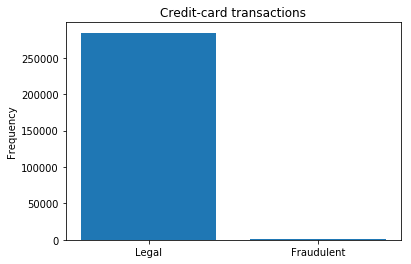

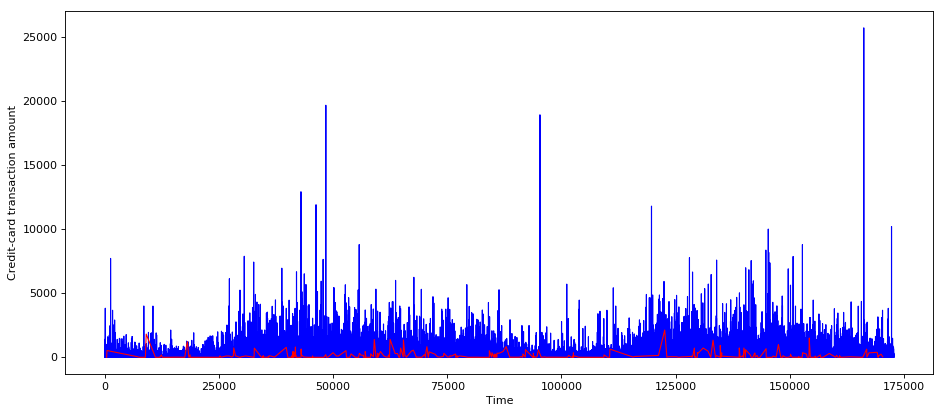

In [5]:
size_l = len(df_legal)
size_f = len(df_fraud)

plt.bar([0,1], [size_l,size_f], align='center', alpha=1)
plt.xticks([0,1],['Legal','Fraudulent'])
plt.ylabel('Frequency')
plt.title('Credit-card transactions')
 
plt.show()

fig, ax = plt.subplots(num=None, figsize=(14, 6), dpi=80, facecolor='w', edgecolor='k')
ax.plot(df_legal[:,0], df_legal[:,29], '-', color='blue', animated = True, linewidth=1)
ax.plot(df_fraud[:,0], df_fraud[:,29], '-', color='red', animated = True, linewidth=1)
plt.ylabel('Credit-card transaction amount')
plt.xlabel('Time')
plt.show()


#### As expected, the dataset is highly imbalanced with a very low percentage of fraudulent transactions. The above time series shows that, apart from the user characteristics V1 to V28, small transaction amounts are also signatures of fraudulent credit-card activities.

### We first train the machine to detect fraudulent transactions with Autoencoders

### Preprocess the transactions data and group the legal transactions for training

In [6]:
X_train, X_rest = train_test_split(df.drop('Time',axis=1), test_size=0.4)  # Split data to 60% training, 20% validation and 20% test
X_val, X_test = train_test_split(X_rest, test_size=0.5)

X_train = X_train[X_train.Class == 0]
X_train = X_train.drop('Class', axis=1)
y_val = X_val['Class']
X_val = X_val.drop('Class', axis=1)
y_test = X_test['Class']
X_test = X_test.drop('Class', axis=1)

X_train = X_train.values
X_val = X_val.values
X_test = X_test.values

print(X_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(170590, 29)
(56961, 29)
(56961,)
(56962, 29)
(56962,)


### Define the autoencoder model

In [7]:
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim, ))
encoder = Dense(24, activation="tanh", 
                activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(12, activation="tanh")(encoder)
encoder = Dense(12, activation="tanh")(encoder)
decoder = Dense(input_dim, activation='relu')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', 
                    loss='mae', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model_autoenc.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = autoencoder.fit(X_train, X_train,
                    epochs=200,
                    batch_size=64,
                    validation_data=(X_val, X_val),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

Train on 170590 samples, validate on 56961 samples
Epoch 1/200
170590/170590 [==============================] - 6s 34us/step - loss: 3.2571 - acc: 0.8778 - val_loss: 3.0009 - val_acc: 0.9006
Epoch 2/200
170590/170590 [==============================] - 6s 34us/step - loss: 2.7668 - acc: 0.9124 - val_loss: 2.6547 - val_acc: 0.9120
Epoch 3/200
170590/170590 [==============================] - 5s 32us/step - loss: 2.4728 - acc: 0.9154 - val_loss: 2.3982 - val_acc: 0.9212
Epoch 4/200
170590/170590 [==============================] - 5s 32us/step - loss: 2.2669 - acc: 0.9137 - val_loss: 2.2308 - val_acc: 0.9246
Epoch 5/200
170590/170590 [==============================] - 6s 33us/step - loss: 2.1090 - acc: 0.9150 - val_loss: 2.0875 - val_acc: 0.9053
Epoch 6/200
170590/170590 [==============================] - 5s 32us/step - loss: 1.9813 - acc: 0.9207 - val_loss: 1.9640 - val_acc: 0.9283
Epoch 7/200
170590/170590 [==============================] - 6s 33us/step - loss: 1.8784 - acc: 0.9275 - val_

### Evaluating the autoencoder results

#### We judge that the autoencoder converges well from both the loss and accuracy learning curves.

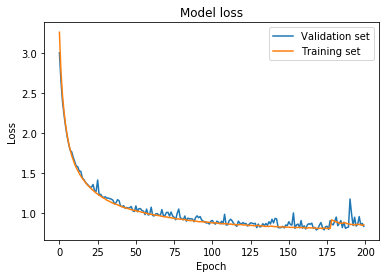

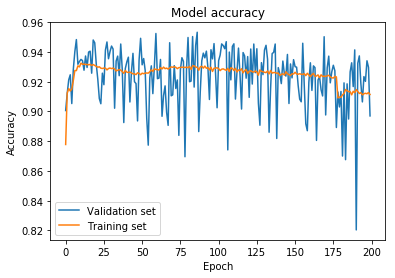

In [8]:
autoencoder = load_model('model_autoenc.h5')

plt.plot(history['val_loss'])
plt.plot(history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation set','Training set']);
plt.show()

plt.plot(history['val_acc'])
plt.plot(history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Validation set','Training set']);
plt.show()

#### Since this dataset is highly imbalanced, we first investigate the confustion matrix for a fixed threshold. It turns out that while the autoencoder prediction is capable of rooting out a large portion of fraudulent transactions, it is at the same time relatively imprecise in recognizing legal transactions.

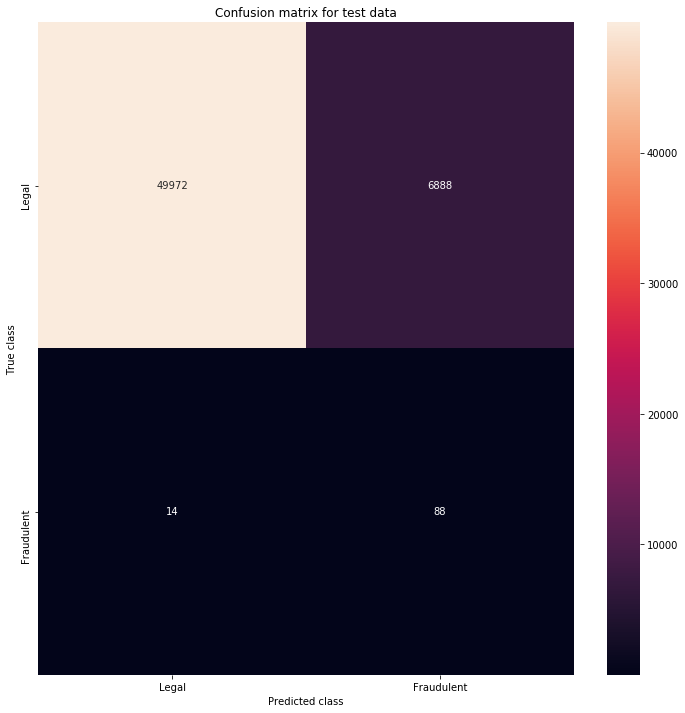

In [9]:
predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})

threshold=1e-7 # normalized to 1

LABELS=['Legal','Fraudulent']
y_pred = [1 if e > threshold*np.max(error_df.reconstruction_error.values) else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for test data")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#### More appropriately, we should look at the precision-recall curve (https://doi.org/10.1371/journal.pone.0118432) and make sure that the area under it is large. This generally corresponds to high precision and high recall.  For our autoencoder, the area under the curve is indeed very small.

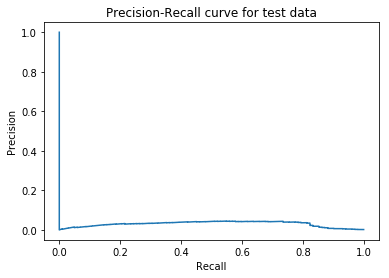

Area Under PR Curve: 0.0295666926281


In [10]:
precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision)
plt.title('Precision-Recall curve for test data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

print("Area Under PR Curve:", auc(recall,precision))

#### We therefore need a better machine-learning algorithm to increase this area.

### We now train the machine with Random-Forest Decision Trees with Apache Spark

In [11]:
splits=df_credit.randomSplit([0.8,0.2])
df_train=splits[0]
df_test=splits[1]

In [12]:
header=df_credit.columns

vectorAssembler=VectorAssembler(inputCols=header,outputCol='features')
labelIndexer = StringIndexer(inputCol="Class", outputCol="indexedClass").fit(df_train)

normalizer = Normalizer(inputCol='features',outputCol='features_norm',p=2.0)

tree_classifier =RandomForestClassifier(labelCol='indexedClass',featuresCol='features_norm',numTrees=2,seed=10)

pipeline=Pipeline(stages=[vectorAssembler,labelIndexer,normalizer,tree_classifier])

In [13]:
model =pipeline.fit(df_train)
predict_train=model.transform(df_train)
predict_test=model.transform(df_test)

### Evaluate the decision-tree predictions first with the confusion matrix

#### This time, rather incredibly, we find that RF only roots out most fraudulent cases, but also recognizes almost all legal transactions from the test dataset.

Statistics for training data: accuracy,precision,recall,F1 0.99941140814 0.999450254642 0.999960398131 0.999705261306
Statistics for test data: accuracy,precision,recall,F1 0.999545017062 0.999544490969 1.0 0.9997721936


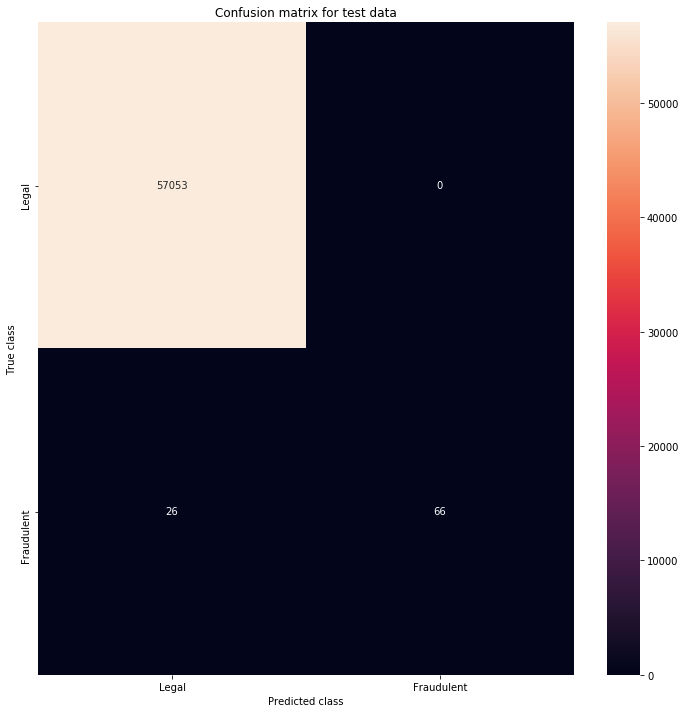

In [14]:
results = predict_train.select(['prediction', 'Class'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
F1=2.*precision*recall/(precision+recall)
print("Statistics for training data: accuracy,precision,recall,F1",accuracy,precision,recall,F1)

results = predict_test.select(['prediction', 'Class'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
F1=2.*precision*recall/(precision+recall)
print("Statistics for test data: accuracy,precision,recall,F1",accuracy,precision,recall,F1)

LABELS=['Legal','Fraudulent']
plt.figure(figsize=(12, 12))
sns.heatmap(cm.astype('int'), xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for test data")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

#### As a matter of fact, we obtain an extremely high score using the more appropriate precision-recall curve.

In [15]:
y_proba=predict_test.select("probability").collect()
y_proba=np.asarray([x[0] for x in y_proba])
y_test=predict_test.select("Class").collect()
y_test=np.asarray([x[0] for x in y_test])

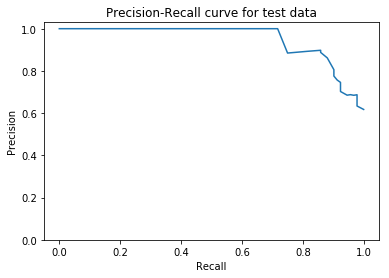

Area under PR curve: 0.9496925151072251


In [17]:
precision, recall, th = precision_recall_curve(y_test, y_proba[:,1])
plt.plot(recall, precision)
plt.title('Precision-Recall curve for test data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0,1.03])
plt.show()

eval = BinaryClassificationEvaluator().setMetricName('areaUnderPR').setLabelCol('Class').setRawPredictionCol("rawPrediction")
print('Area under PR curve:',eval.evaluate(predict_test))

#### We therefore conclude that Decision Trees are the better alternative for detecting credit-card frauduluent activities. Slight enhancement can be provided by Gradient Boosted Trees.

In [18]:
vectorAssembler=VectorAssembler(inputCols=header,outputCol='features')
labelIndexer = StringIndexer(inputCol="Class", outputCol="indexedClass").fit(df_train)

normalizer = Normalizer(inputCol='features',outputCol='features_norm',p=2.0)

tree_classifier =GBTClassifier(labelCol='indexedClass',featuresCol='features_norm',maxIter=1)

pipeline=Pipeline(stages=[vectorAssembler,labelIndexer,normalizer,tree_classifier])

model =pipeline.fit(df_train)
predict_train=model.transform(df_train)
predict_test=model.transform(df_test)

Statistics for test data: accuracy,precision,recall,F1 1.0 1.0 1.0 1.0


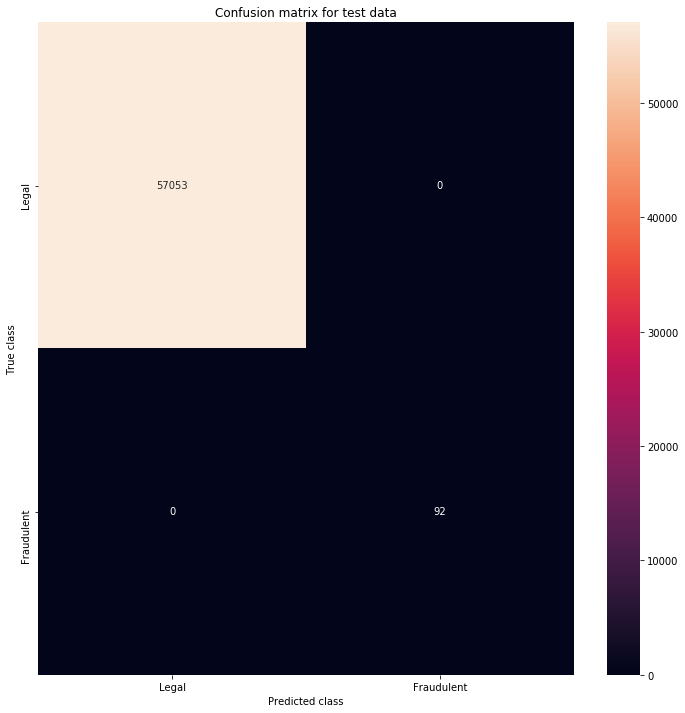

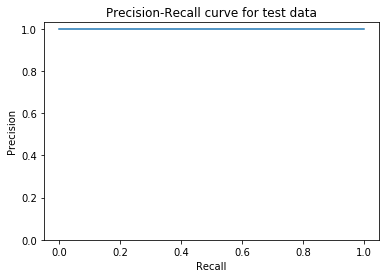

Area under PR curve: 1.0


In [19]:
results = predict_test.select(['prediction', 'Class'])
predictionAndLabels=results.rdd
metrics = MulticlassMetrics(predictionAndLabels)

cm=metrics.confusionMatrix().toArray()
accuracy=(cm[0][0]+cm[1][1])/cm.sum()
precision=(cm[0][0])/(cm[0][0]+cm[1][0])
recall=(cm[0][0])/(cm[0][0]+cm[0][1])
F1=2.*precision*recall/(precision+recall)
print("Statistics for test data: accuracy,precision,recall,F1",accuracy,precision,recall,F1)

plt.figure(figsize=(12, 12))
sns.heatmap(cm.astype('int'), xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix for test data")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

y_proba=predict_test.select("probability").collect()
y_proba=np.asarray([x[0] for x in y_proba])
y_test=predict_test.select("Class").collect()
y_test=np.asarray([x[0] for x in y_test])

precision, recall, th = precision_recall_curve(y_test, y_proba[:,1])
plt.plot(recall, precision)
plt.title('Precision-Recall curve for test data')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0,1.03])
plt.show()

eval = BinaryClassificationEvaluator().setMetricName('areaUnderPR').setLabelCol('Class').setRawPredictionCol("rawPrediction")
print('Area under PR curve:',eval.evaluate(predict_test))

### Conclusion

We have carried out two different classes of machine/deep-learning algorithms to train the computer for credit-card fraud detection, namely autoencoder neural networks and decision-tree classifiers. It turns out that the autoencoder neural networks quite often misclassifies legal transactions as fraudulent on test/validation data even though they manage to root out a large portion of fraudulent transactions. On the other hand, decision-tree algorithms are more reliable in both recognizing legal transactions and rooting out fraudulent ones. Our evaluation shows that Gradient Boosted Trees give the most promising results.